## load library & data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('../data/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip')
df_test = pd.read_csv('../data/airbnb-recruiting-new-user-bookings/test_users.csv.zip')
df_train.shape, df_test.shape

((213451, 16), (62096, 15))

In [3]:
display(df_train.head())
display(df_test.head())

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [4]:
# label 조회
set(df_train.columns) - set(df_test.columns)

{'country_destination'}

In [5]:
# label 저장
labels = df_train.country_destination.values
id_test = df_test.id

# label drop
# 저장은 안하는 모습
df_train.drop(['country_destination'], axis=1)

# label drop 후 train test concat
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

In [6]:
print(df_all.shape)
df_all.head()

(275547, 16)


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


## EDA

### 결측치 조회

In [7]:
# 모든 컬럼 순회
for i in df_all.columns:
    # 결측치 개수 파악
    ab = df_all[i].isnull().sum()
    # 결측치가 0이 아니라면 개수 출력
    if ab != 0:
        print(i + " has {} null values.".format(ab))
        print()

date_first_booking has 186639 null values.

age has 116866 null values.

first_affiliate_tracked has 6085 null values.

country_destination has 62096 null values.



In [8]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275547 entries, 0 to 275546
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       275547 non-null  object 
 1   date_account_created     275547 non-null  object 
 2   timestamp_first_active   275547 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   275547 non-null  object 
 5   age                      158681 non-null  float64
 6   signup_method            275547 non-null  object 
 7   signup_flow              275547 non-null  int64  
 8   language                 275547 non-null  object 
 9   affiliate_channel        275547 non-null  object 
 10  affiliate_provider       275547 non-null  object 
 11  first_affiliate_tracked  269462 non-null  object 
 12  signup_app               275547 non-null  object 
 13  first_device_type        275547 non-null  object 
 14  firs

In [9]:
# id, label drop
# data_first_booking은 결측치가 절반 이상이라 drop한 것으로 추정
df_all = df_all.drop(['id','country_destination','date_first_booking'], axis=1)

In [10]:
# 결측치 재조회
for i in df_all.columns:
    ab = df_all[i].isnull().sum()
    if ab != 0:
        print(i + " has {} null values.".format(ab))
        print()

age has 116866 null values.

first_affiliate_tracked has 6085 null values.



In [11]:
df_all.head()

,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,2010-06-28,20090319043255,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,2011-12-05,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,2010-09-14,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


In [12]:
df_all.gender.value_counts()

-unknown-    129480
FEMALE        77524
MALE          68209
OTHER           334
Name: gender, dtype: int64

In [13]:
# 나이 max 값이 이상함
df_all.age.describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

In [14]:
# 15살 미만, 100살 이상은 NaN 처리
df_all[df_all['age']<15].age = np.nan
df_all[df_all['age']>=100].age = np.nan

In [15]:
# category type으로 변경
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method',
    'signup_flow'
]

for categorical_feature in categorical_features:
    df_all[categorical_feature] = df_all[categorical_feature].astype('category')

In [16]:
# category 확인 작업
df_all.select_dtypes(exclude='number').columns

Index(['date_account_created', 'gender', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser'],
      dtype='object')

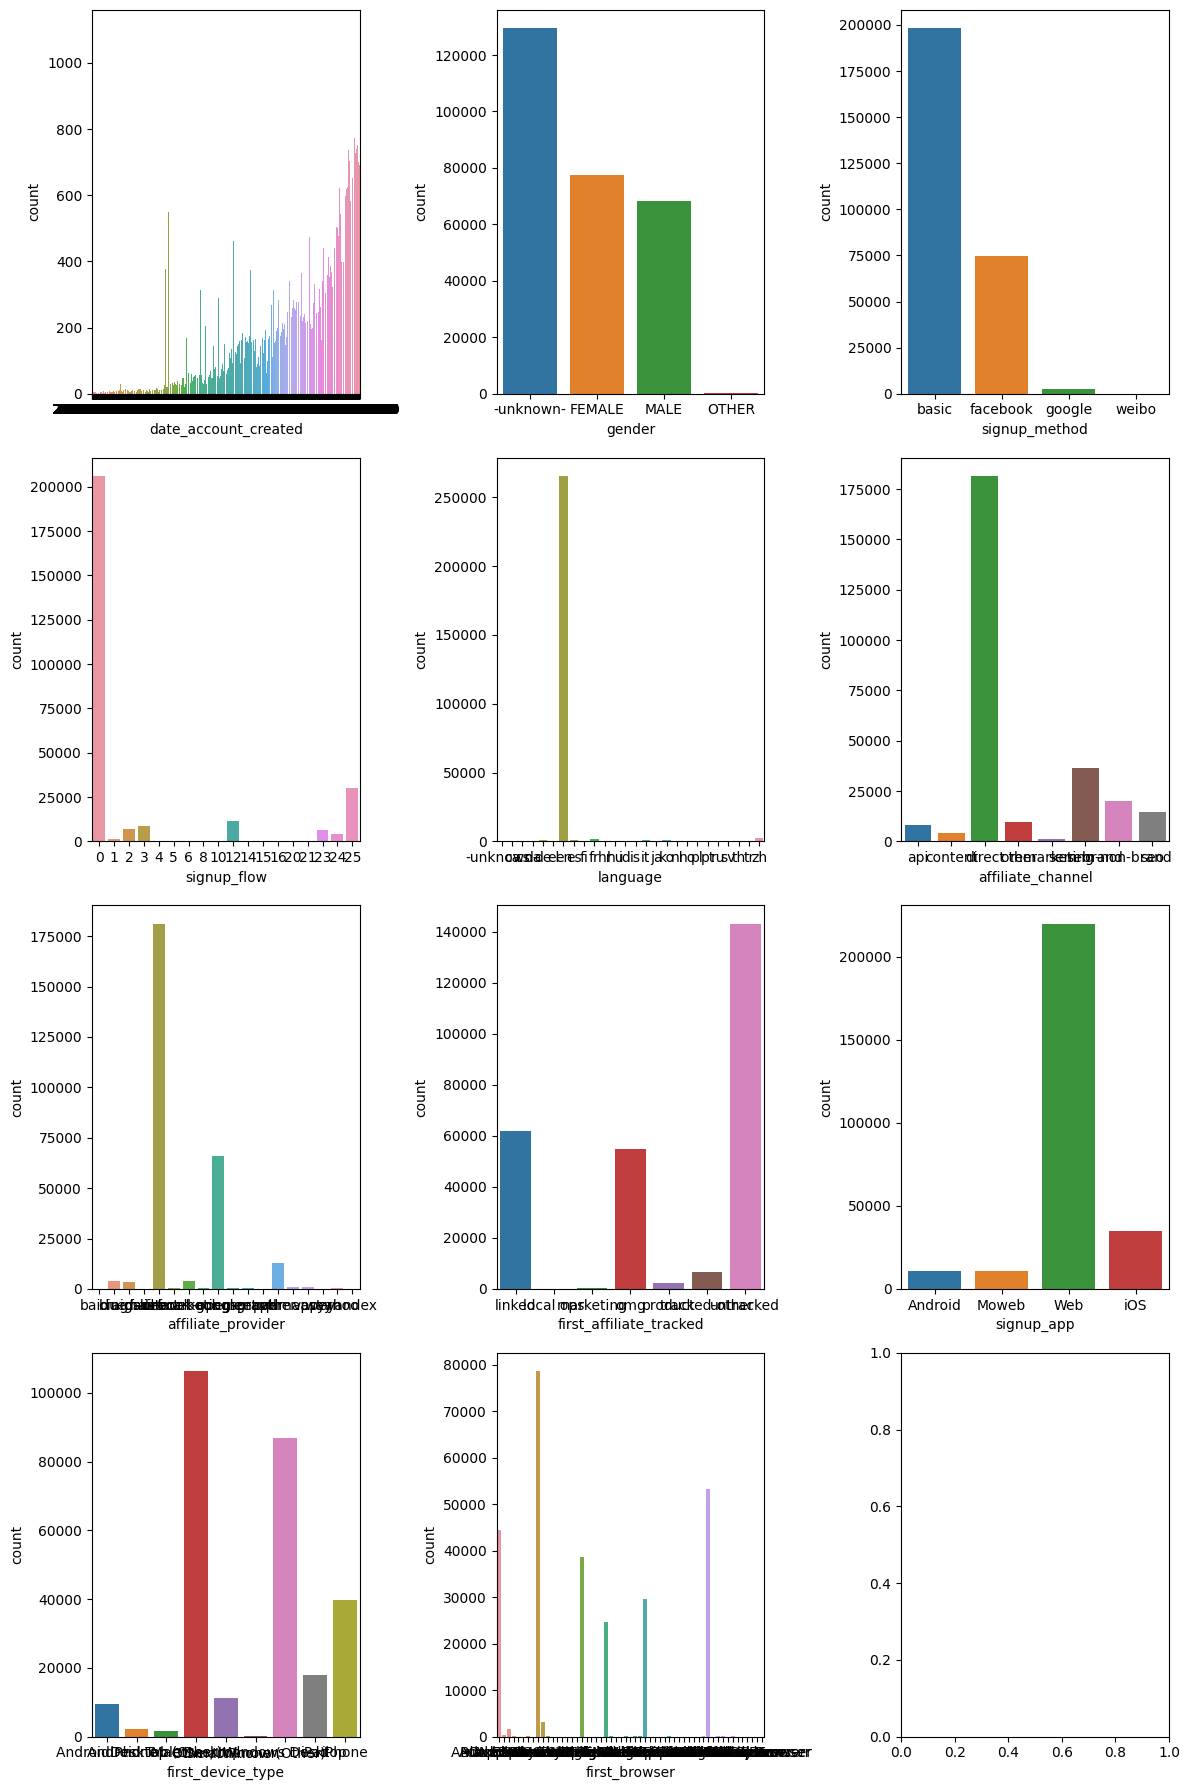

In [17]:
fig, axes = plt.subplots(4, 3, figsize=(12, 18))
for i ,col in enumerate(df_all.select_dtypes(exclude='number').columns):
    sns.countplot(data=df_all, x=col, ax=axes[i//3, i%3])
plt.tight_layout()

In [18]:
# datetime type으로 변경
df_all['date_account_created'] = pd.to_datetime(df_all['date_account_created'])
df_all['timestamp_first_active'] = pd.to_datetime(df_all['timestamp_first_active'], format='%Y%m%d%H%M%S')

## Visualizations

In [19]:
sns.set_style('whitegrid')

# 전체 스케일 조정
# "paper", "notebook", "talk", "poster"
# default="notebook" 
sns.set_context("talk")

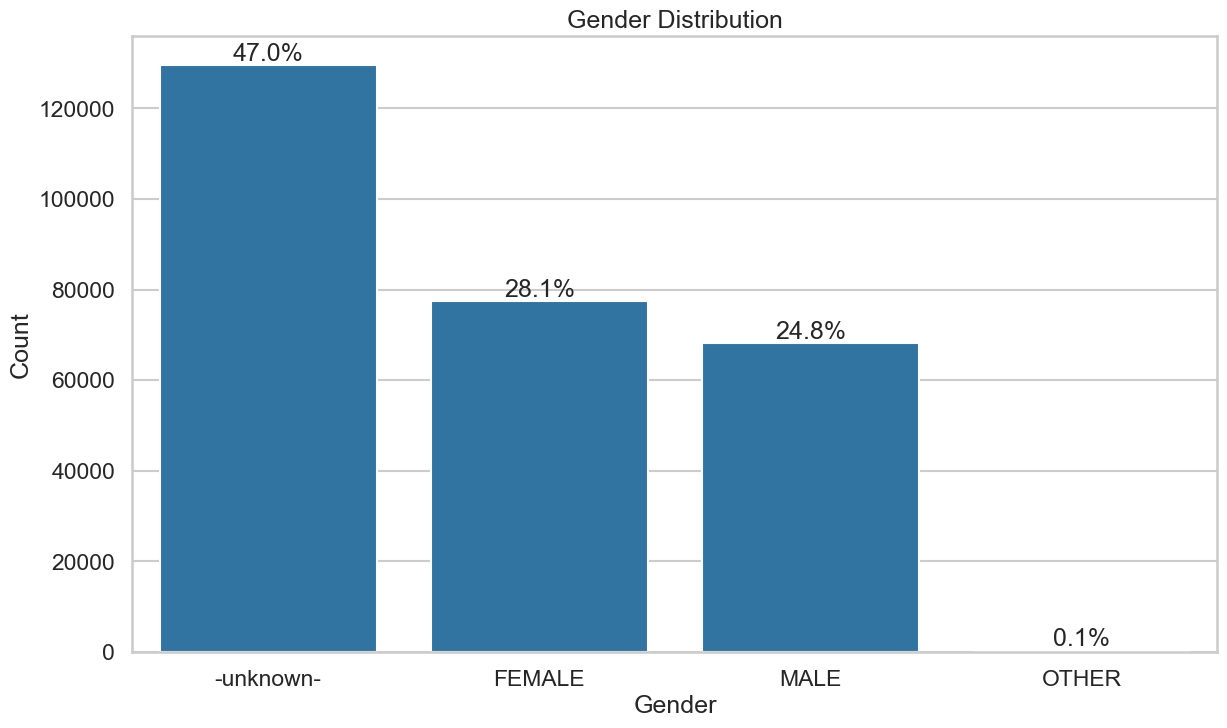

In [20]:
plt.figure(figsize=(14,8))

# 성별 수 정렬
order1 = df_all['gender'].value_counts().index
sns.countplot(data=df_all, x='gender', order=order1, color=sns.color_palette()[0])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
order2 = df_all['gender'].value_counts()

for i in range(order2.shape[0]):
    count = order2[i]
    strt='{:0.1f}%'.format(100*count / df_all.shape[0])
    plt.text(i, count+1000, strt, ha='center')

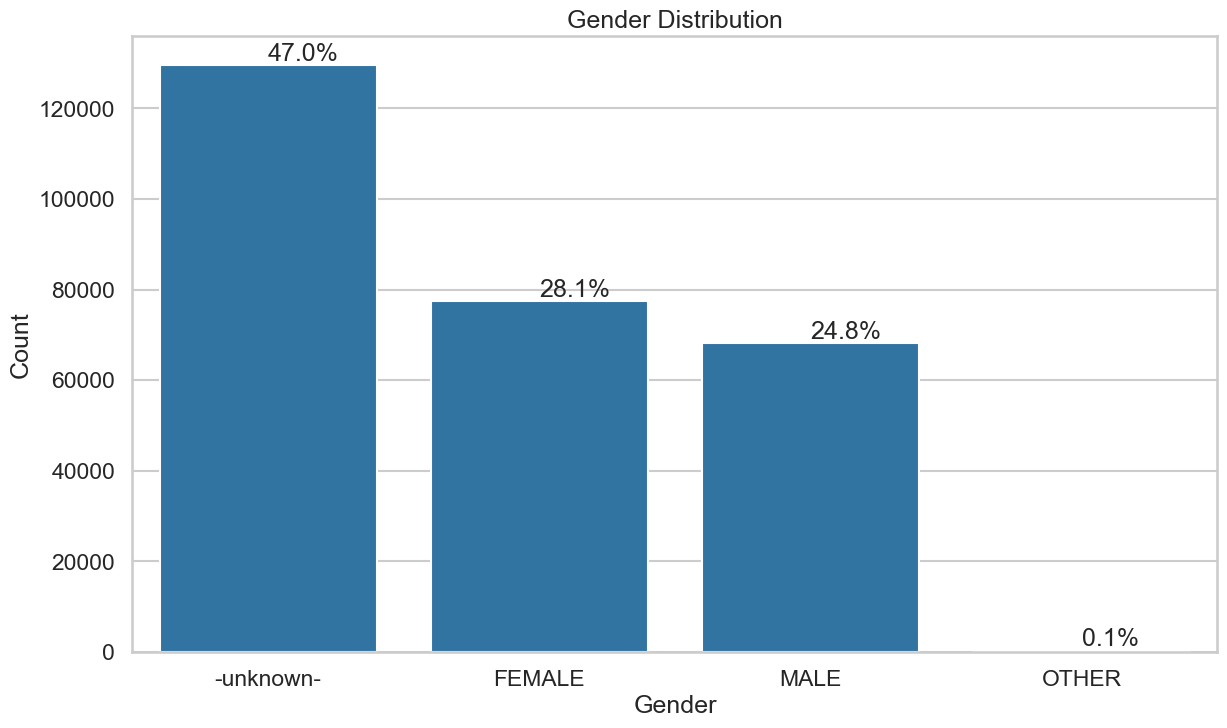

In [21]:
plt.figure(figsize=(14,8))

# 성별 수 정렬
order1 = df_all['gender'].value_counts().index
sns.countplot(data=df_all, x='gender', order=order1, color=sns.color_palette()[0])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
order2 = df_all['gender'].value_counts()

for i in range(order2.shape[0]):
    count = order2[i]
    strt='{:0.1f}%'.format(100*count / df_all.shape[0])

    # ha : Set the horizontal alignment relative to the anchor point.
    plt.text(i, count+1000, strt, ha='left')

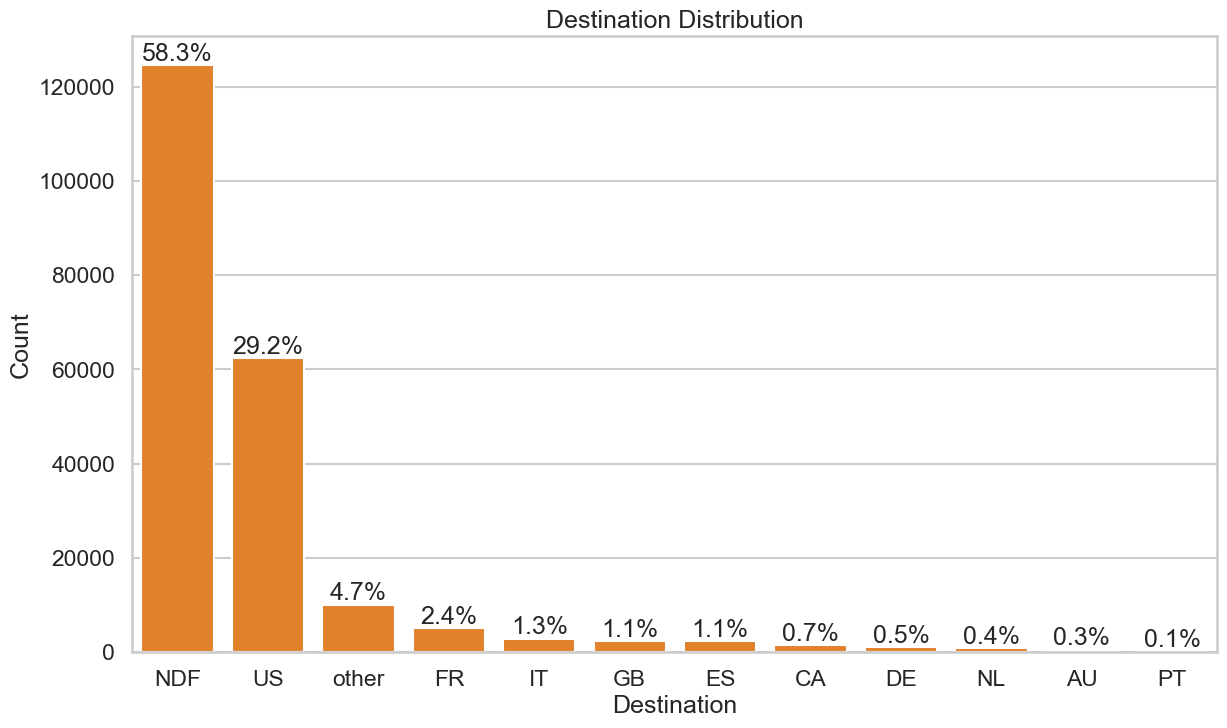

In [22]:
plt.figure(figsize=(14,8))
order1 = df_train['country_destination'].value_counts().index
sns.countplot(data = df_train, x = 'country_destination', order = order1, color = sns.color_palette()[1])
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Destination Distribution')
order2 = df_train['country_destination'].value_counts()

for i in range(order2.shape[0]):
    count = order2[i]
    strt='{:0.1f}%'.format(100*count / df_train.shape[0])
    plt.text(i,count+1000,strt,ha='center')

category type에 정렬을 적용할 때 사용하는 것으로 추정
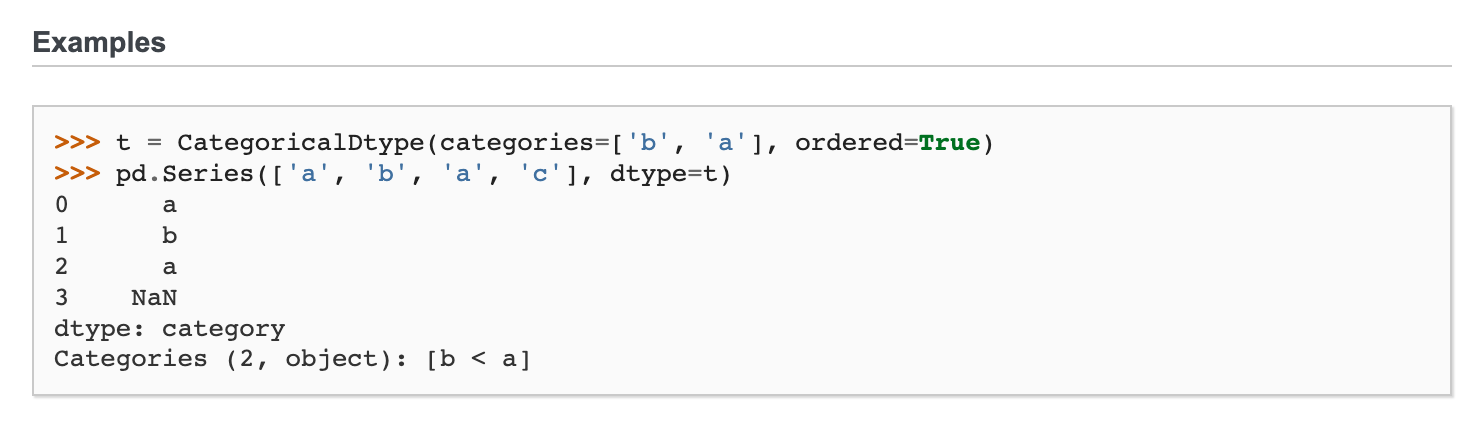

In [23]:
# 아이디 생성 날짜에서 연도 추출
df_all['acc_year'] = df_all['date_account_created'].dt.year

df1 = df_all.groupby('acc_year').count()
df1.head()

years = [2010, 2011, 2012, 2013, 2014]
# Type for categorical data with the categories and orderedness
yearsOrder=pd.api.types.CategoricalDtype(ordered=True, categories=years)
df1.reset_index(inplace=True)
df1.acc_year = df1.acc_year.astype(yearsOrder)

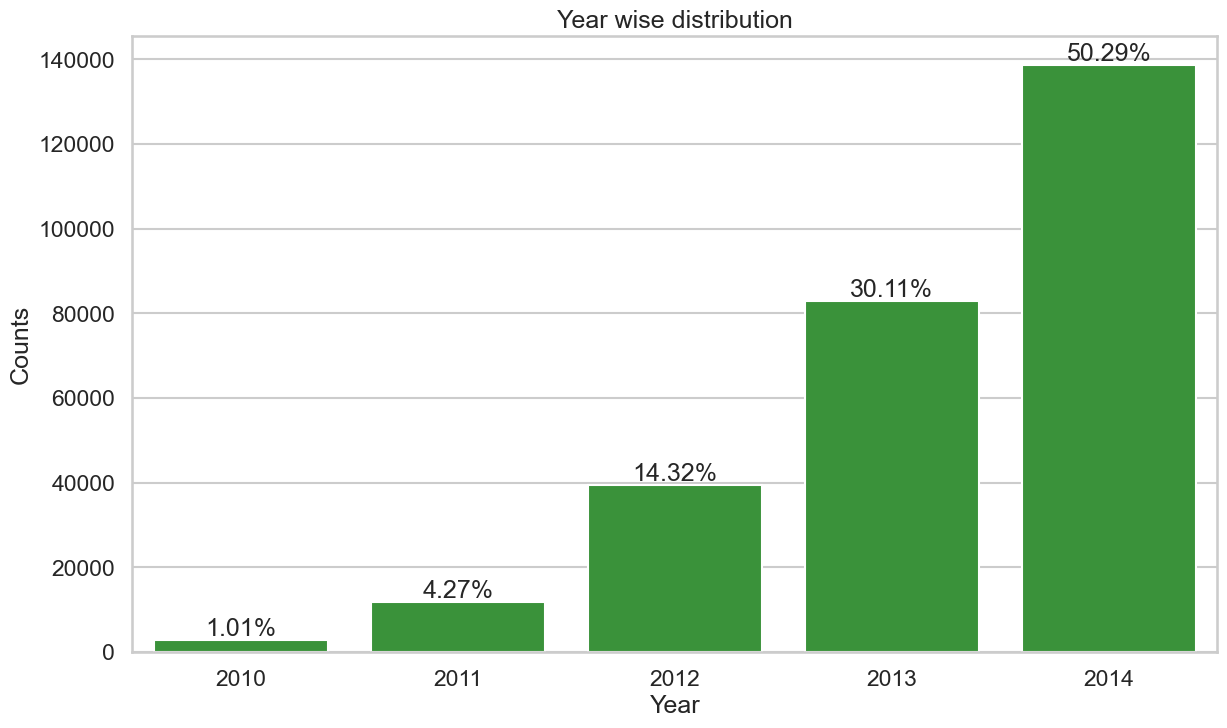

In [24]:
plt.figure(figsize=[14,8])
sns.barplot(data=df1,x='acc_year',y='affiliate_provider',color=sns.color_palette()[2]);
plt.title('Year wise distribution');
plt.xlabel('Year')
plt.ylabel('Counts')
for i in range(df1.shape[0]):
    count=df1.iloc[i]['affiliate_provider']
    strt='{:0.2f}%'.format(100*count/df_all.shape[0])
    plt.text(i,count+1000,strt,ha='center')

In [25]:
# 2014년도의 데이터 추출
df2 = df_all[df_all['date_account_created'].dt.year==2014]

# 2014년도 데이터 날짜 타입 표현 방식 설정
df2['monthYear14'] = df2['date_account_created'].map(lambda x: x.strftime('%m-%Y'))
df2 = df2.groupby('monthYear14').count()

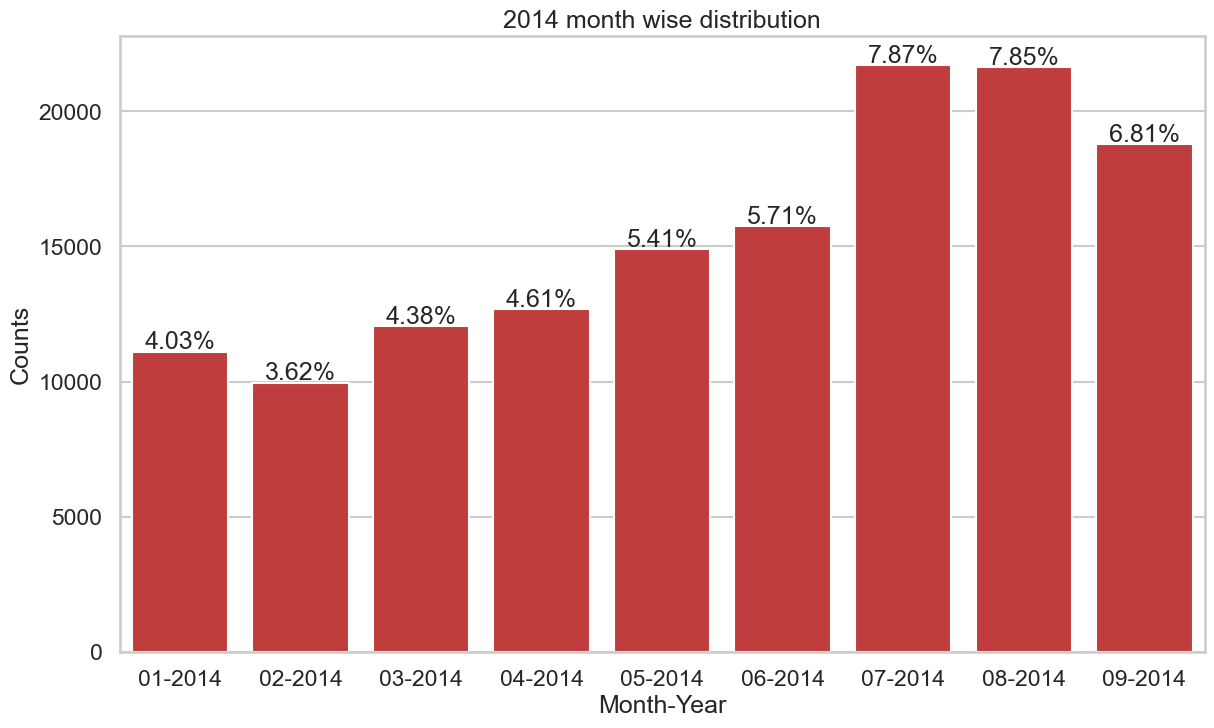

In [26]:
# 월별 순으로 그래프 시각화
plt.figure(figsize=[14,8])
sns.barplot(data=df2, x=df2.index, y='affiliate_provider', color=sns.color_palette()[3]);
plt.title('2014 month wise distribution');
plt.xlabel('Month-Year')
plt.ylabel('Counts')
for i in range(df2.shape[0]):
    count=df2.iloc[i]['affiliate_provider']
    strt='{:0.2f}%'.format(100*count/df_all.shape[0])
    plt.text(i, count+100, strt, ha='center')

In [27]:
# 나이에 따라 연령대 파생변수 생성
df_all['member_age_bins']=df_all['age'].apply(lambda x: '18 - 20' if 18<x<=20
                                                  else '20 - 30' if 20<x<=30
                                                  else '30 - 40' if 30<x<=40
                                                  else '40 - 50' if 40<x<=50
                                                  else '50 - 60' if 50<x<=60
                                                  else '60-70' if 60<x<=70
                                                  else '70+' if 70<x<=100
                                                  else np.nan)

In [29]:
# 알맞게 생성된 것 확인 
df_all[['age', 'member_age_bins']]

,age,member_age_bins
0,NaN,NaN
1,38.0,30 - 40
2,56.0,50 - 60
3,42.0,40 - 50
4,41.0,40 - 50
...,...,...
275542,31.0,30 - 40
275543,NaN,NaN
275544,NaN,NaN
275545,NaN,NaN


In [30]:
# 2013년 데이터만 추출
df3 = df_all[df_all['date_account_created'].dt.year==2013]

# 날짜 출력 형태
df3['monthYear13'] = df3['date_account_created'].map(lambda x: x.strftime('%m-%Y'))
df3 = df3.groupby('monthYear13').count()

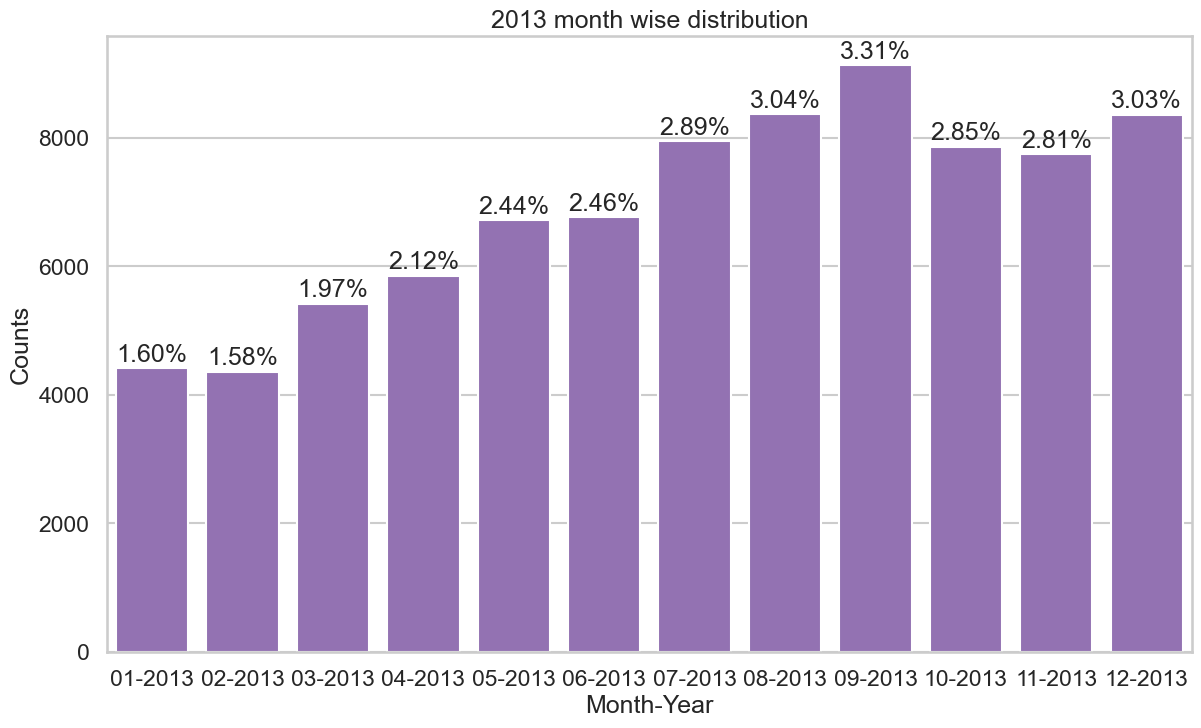

In [31]:
# 2013년 데이터 월별 시각화
plt.figure(figsize=[14,8])
sns.barplot(data=df3, x=df3.index, y='affiliate_provider', color=sns.color_palette()[4]);
plt.title('2013 month wise distribution');
plt.xlabel('Month-Year')
plt.ylabel('Counts')
for i in range(df3.shape[0]):
    count=df3.iloc[i]['affiliate_provider']
    strt='{:0.2f}%'.format(100*count/df_all.shape[0])
    plt.text(i,count+100,strt,ha='center')

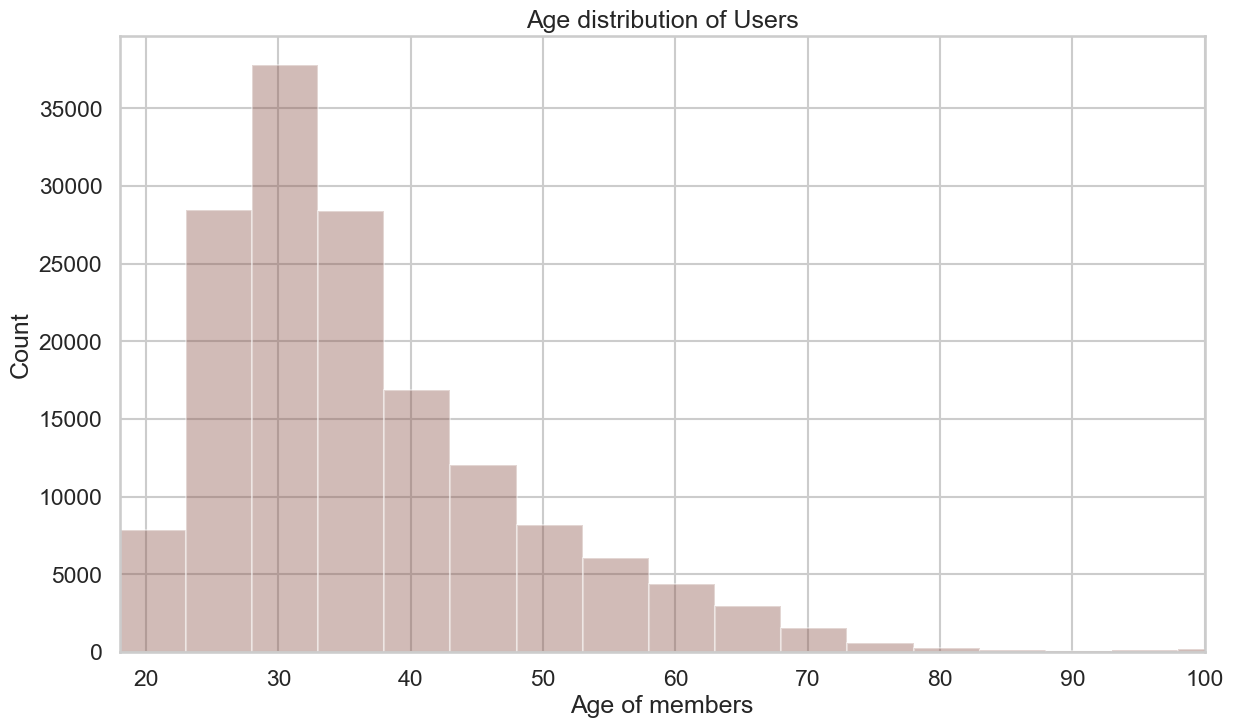

In [32]:
plt.figure(figsize=[14,8])
# 연령대에 결측치를 제거하고 분포 확인
sns.distplot(df_all.age.dropna(), bins=np.arange(18,100+5,5), color=sns.color_palette()[5], kde=False);
plt.xlabel('Age of members')
plt.ylabel('Count')
plt.title('Age distribution of Users')
plt.xlim(18,100);

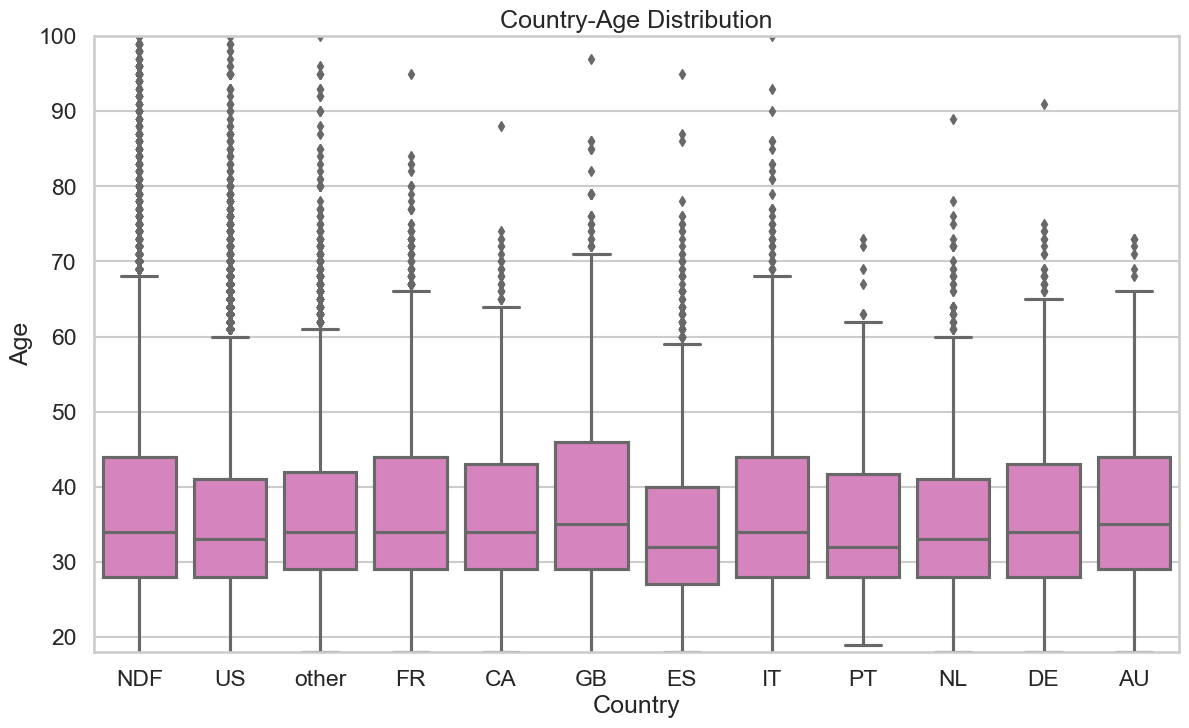

In [33]:
# 여행 국가별 연령대 시각화
plt.figure(figsize=[14,8])
sns.boxplot(data=df_train, y='age', x='country_destination', color=sns.color_palette()[6]);
plt.ylim(18,100)
plt.xlabel('Country');
plt.ylabel('Age');
plt.title('Country-Age Distribution');

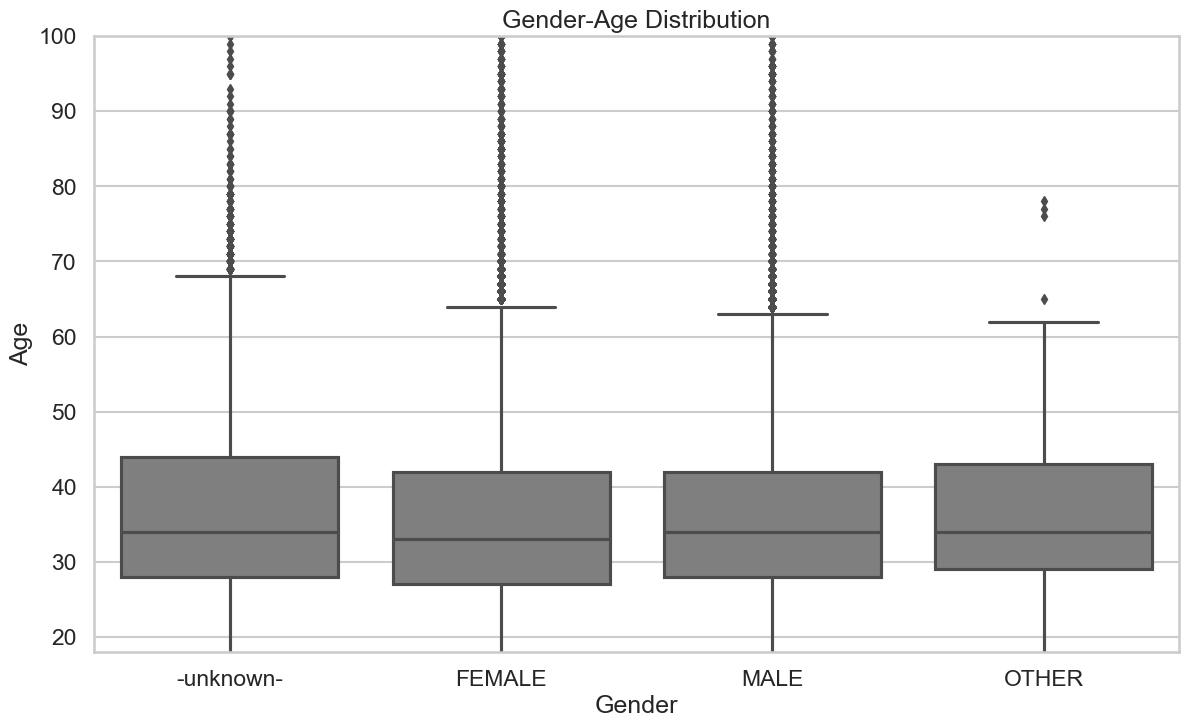

In [34]:
# 연령대 별 성별 시각화
plt.figure(figsize=[14,8])
sns.boxplot(data=df_all, y='age', x='gender', color=sns.color_palette()[7]);
plt.ylim(18,100)
plt.xlabel('Gender');
plt.ylabel('Age');
plt.title('Gender-Age Distribution');

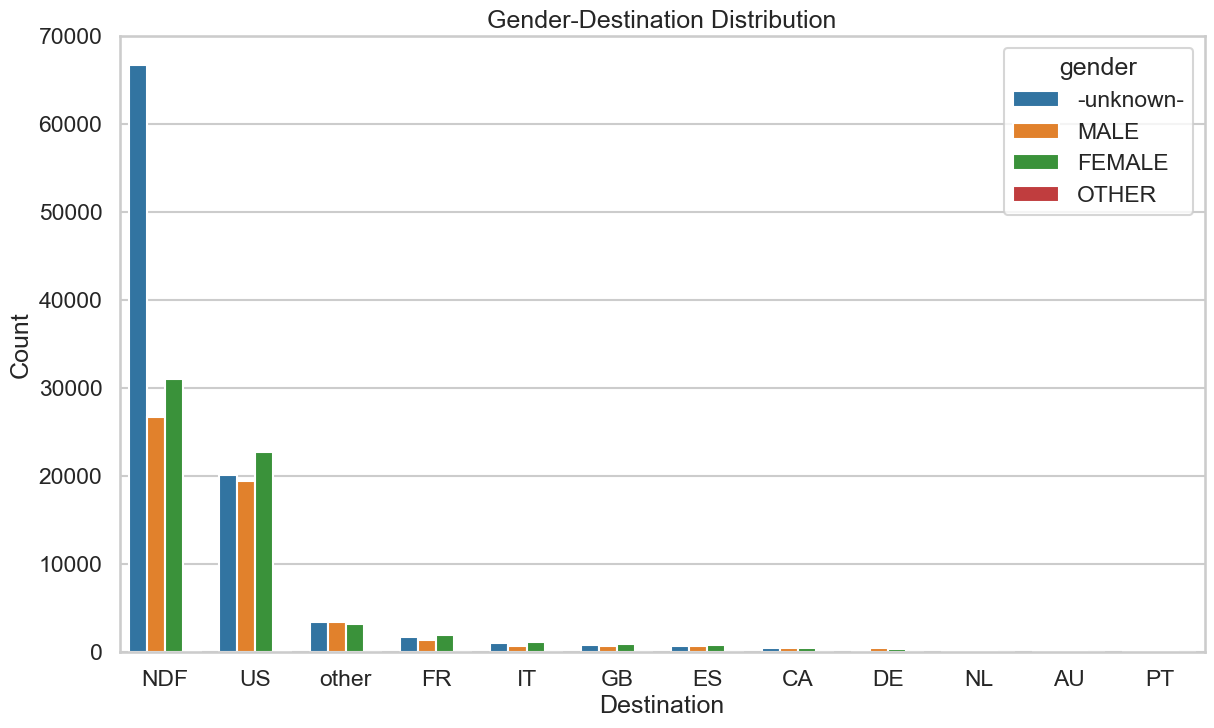

In [35]:
# 국가 별 성별 시각화
plt.figure(figsize=(14,8))
order1 = df_train['country_destination'].value_counts().index
sns.countplot(data = df_train, x='country_destination', order=order1, hue='gender')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Gender-Destination Distribution')
order2 = df_train['country_destination'].value_counts()

In [36]:
# 2013년 데이터만 추출
df3 = df_all[df_all['date_account_created'].dt.year==2013]
df3['monthYear13'] = df3['date_account_created'].map(lambda x: x.strftime('%m-%Y'))

df3= df3.groupby(['monthYear13','member_age_bins']).count()

df3.reset_index(inplace=True)

Text(0, 0.5, 'Counts')

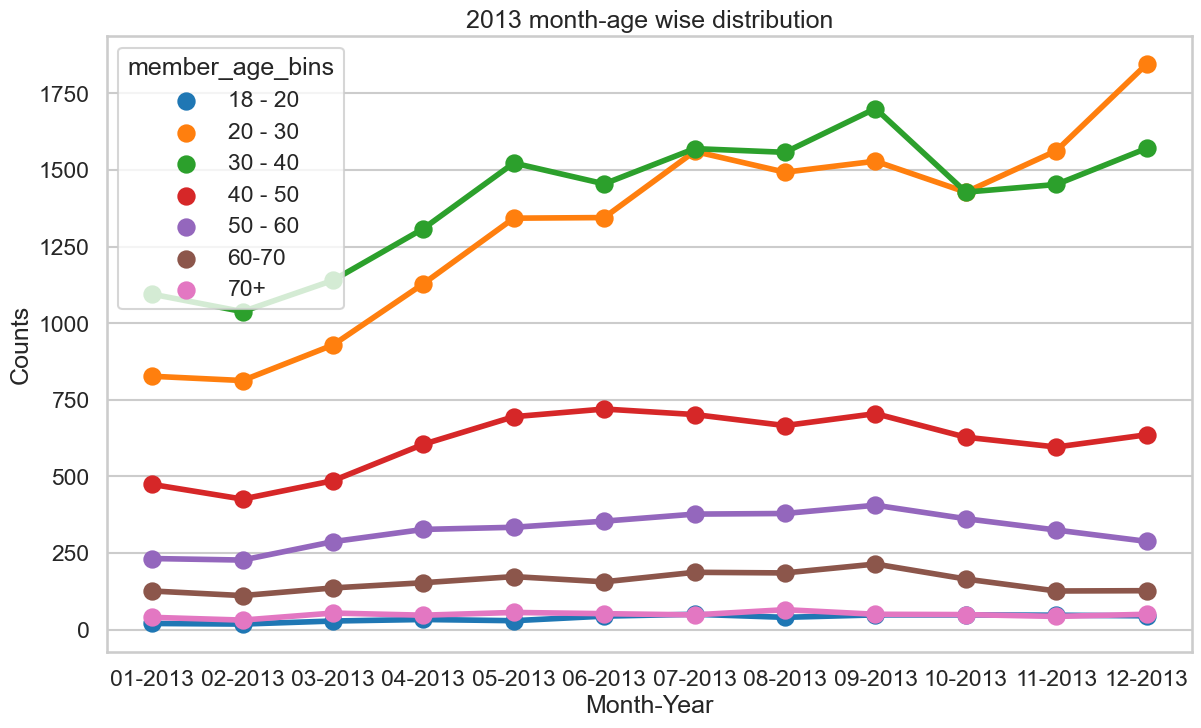

In [37]:
# 2013년 연령대 추이
plt.figure(figsize=[14,8])
sns.pointplot(data=df3, x='monthYear13', y='affiliate_provider', hue='member_age_bins');
plt.title('2013 month-age wise distribution');
plt.xlabel('Month-Year')
plt.ylabel('Counts')

In [38]:
df3 = df_all[df_all['date_account_created'].dt.year==2013]
df3['monthYear13'] = df3['date_account_created'].map(lambda x: x.strftime('%m-%Y'))

df3= df3.groupby(['monthYear13','gender']).count()

df3.reset_index(inplace=True)

Text(0, 0.5, 'Counts')

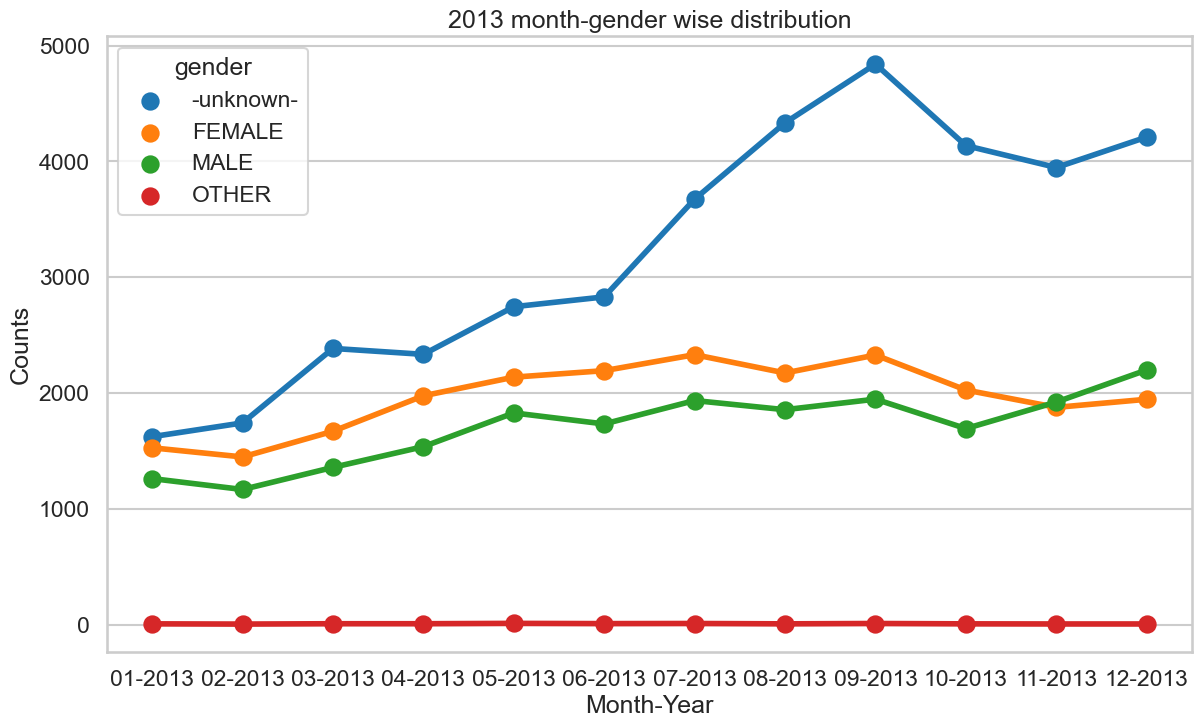

In [39]:
# 2013년 데이터 성별 추이
plt.figure(figsize=[14,8])
sns.pointplot(data=df3, x='monthYear13', y='affiliate_provider', hue='gender');
plt.title('2013 month-gender wise distribution');
plt.xlabel('Month-Year')
plt.ylabel('Counts')

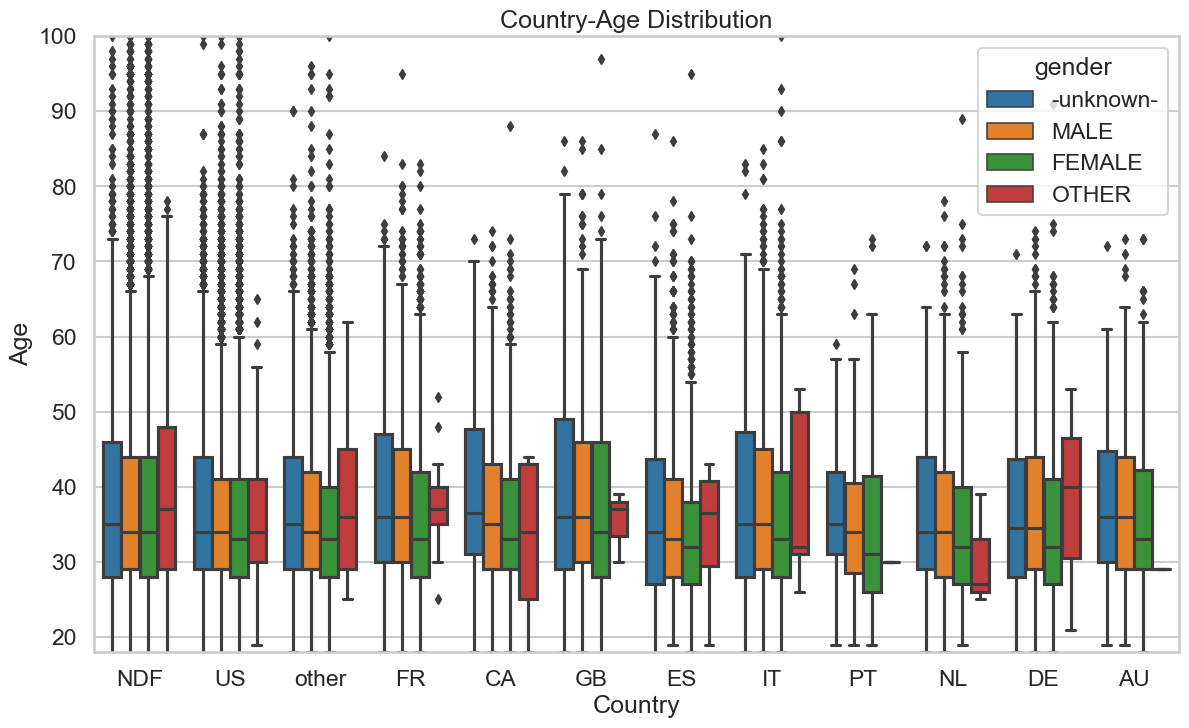

In [40]:
# 국가별 연령대별 성별
plt.figure(figsize=[14,8])
sns.boxplot(data=df_train, y='age', x='country_destination', hue='gender');
plt.ylim(18,100)
plt.xlabel('Country');
plt.ylabel('Age');
plt.title('Country-Age Distribution');